In [16]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install catboost


EDA

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [19]:
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

train = pd.read_csv('/content/drive/MyDrive/train (4).csv')
test = pd.read_csv('/content/drive/MyDrive/x_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/sample_submission (2).csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Submission shape: {submission.shape}')

train.head()

Train shape: (1100000, 21)
Test shape: (100000, 20)
Submission shape: (100000, 2)


,ID,Years Lived,Sex,Yearly Earnings,Relationship Status,Dependent Count,Academic Standing,Job Title,Wellness Index,Region,...,Prior Claims,Automobile Age,Financial Rating,Coverage Period,Coverage Commencement,Client Review,Tobacco Use,Physical Activity,Asset Category,Policy Cost
0,0,26.0,Man,8071.0,Unmarried,NaN,Secondary,NaN,17.927378,City,...,0.0,4.0,622.0,2.0,2024-06-10 15:21:39.261856,NaN,Smoker,Everyday,Residence,533.0
1,1,42.0,Man,49.0,Unmarried,2.0,Undergraduate,Jobless,49.828507,City,...,1.0,15.0,568.0,6.0,2023-01-06 15:21:39.272456,Moderate,Smoker,Once a Week,Unit,4795.0
2,2,52.0,Man,80793.0,Spouse,2.0,Doctorate,Jobless,27.539608,Exurban,...,2.0,2.0,467.0,7.0,2021-03-18 15:21:39.237118,Satisfactory,Non-Smoker,Seldom,Residence,151.0
3,3,33.0,Man,30663.0,Unmarried,1.0,Undergraduate,Freelancer,24.355045,Countryside,...,1.0,10.0,710.0,2.0,2023-08-28 15:21:39.102694,Unsatisfactory,Non-Smoker,Seldom,Residence,588.0
4,4,34.0,Man,59638.0,Spouse,0.0,Undergraduate,NaN,33.394840,Countryside,...,1.0,10.0,431.0,2.0,2024-03-17 15:21:39.171102,Unsatisfactory,Smoker,Once a Month,Residence,662.0


In [20]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1100000 non-null  int64  
 1   Years Lived            1082781 non-null  float64
 2   Sex                    1100000 non-null  object 
 3   Yearly Earnings        1058849 non-null  float64
 4   Relationship Status    1083018 non-null  object 
 5   Dependent Count        999297 non-null   float64
 6   Academic Standing      1100000 non-null  object 
 7   Job Title              771458 non-null   object 
 8   Wellness Index         1031954 non-null  float64
 9   Region                 1100000 non-null  object 
 10  Coverage Class         1100000 non-null  object 
 11  Prior Claims           766140 non-null   float64
 12  Automobile Age         1099994 non-null  float64
 13  Financial Rating       973595 non-null   float64
 14  Coverage Period   

In [21]:
train.describe()

,ID,Years Lived,Yearly Earnings,Dependent Count,Wellness Index,Prior Claims,Automobile Age,Financial Rating,Coverage Period,Policy Cost
count,1.100000e+06,1.082781e+06,1.058849e+06,999297.000000,1.031954e+06,766140.000000,1.099994e+06,973595.000000,1.099999e+06,1.100000e+06
mean,5.499995e+05,4.114396e+01,3.273969e+04,2.009234,2.561357e+01,1.003279,9.573080e+00,593.003554,5.016976e+00,1.102681e+03
std,3.175428e+05,1.353912e+01,3.218211e+04,1.417255,1.220411e+01,0.983413,5.776708e+00,149.951723,2.594547e+00,8.650824e+02
min,0.000000e+00,1.800000e+01,1.000000e+00,0.000000,2.012237e+00,0.000000,0.000000e+00,300.000000,1.000000e+00,2.000000e+01
25%,2.749998e+05,3.000000e+01,7.991000e+03,1.000000,1.591814e+01,0.000000,5.000000e+00,468.000000,3.000000e+00,5.140000e+02
50%,5.499995e+05,4.100000e+01,2.389700e+04,2.000000,2.458200e+01,1.000000,1.000000e+01,595.000000,5.000000e+00,8.720000e+02
75%,8.249992e+05,5.300000e+01,4.463300e+04,3.000000,3.452768e+01,2.000000,1.500000e+01,721.000000,7.000000e+00,1.509000e+03
max,1.099999e+06,6.400000e+01,1.499970e+05,4.000000,5.897591e+01,9.000000,1.900000e+01,849.000000,9.000000e+00,4.999000e+03


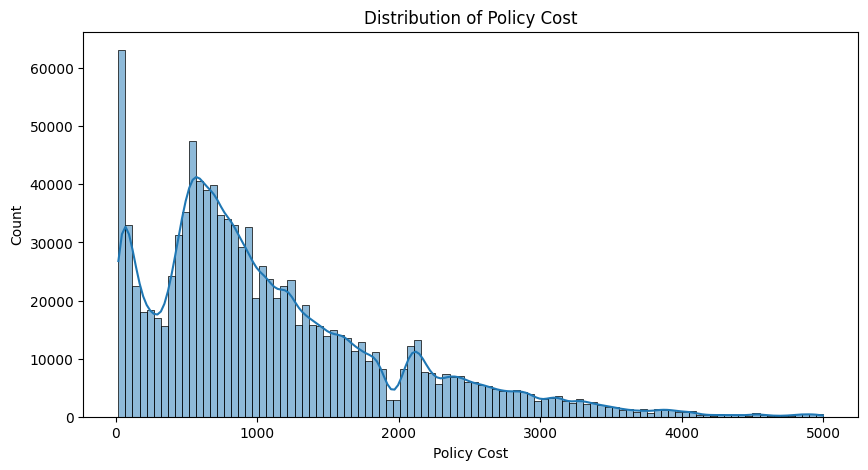

Missing % in train:
 Years Lived             1.565364
Yearly Earnings         3.741000
Relationship Status     1.543818
Dependent Count         9.154818
Job Title              29.867455
Wellness Index          6.186000
Prior Claims           30.350909
Automobile Age          0.000545
Financial Rating       11.491364
Coverage Period         0.000091
Client Review           6.481545
dtype: float64
Missing % in test:
 Years Lived             1.486
Yearly Earnings         3.798
Relationship Status     1.547
Dependent Count         8.969
Job Title              29.533
Wellness Index          6.030
Prior Claims           30.169
Financial Rating       11.477
Client Review           6.527
dtype: float64
Remaining missing values in train:
 Series([], dtype: int64)
Remaining missing values in test:
 Series([], dtype: int64)


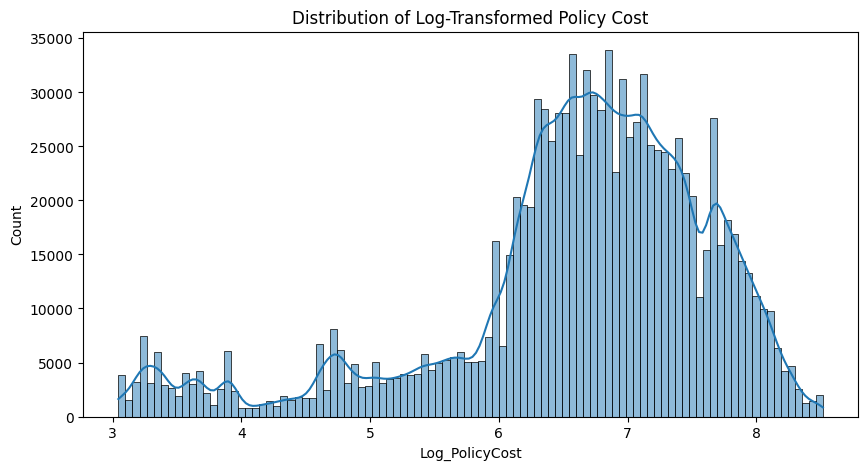

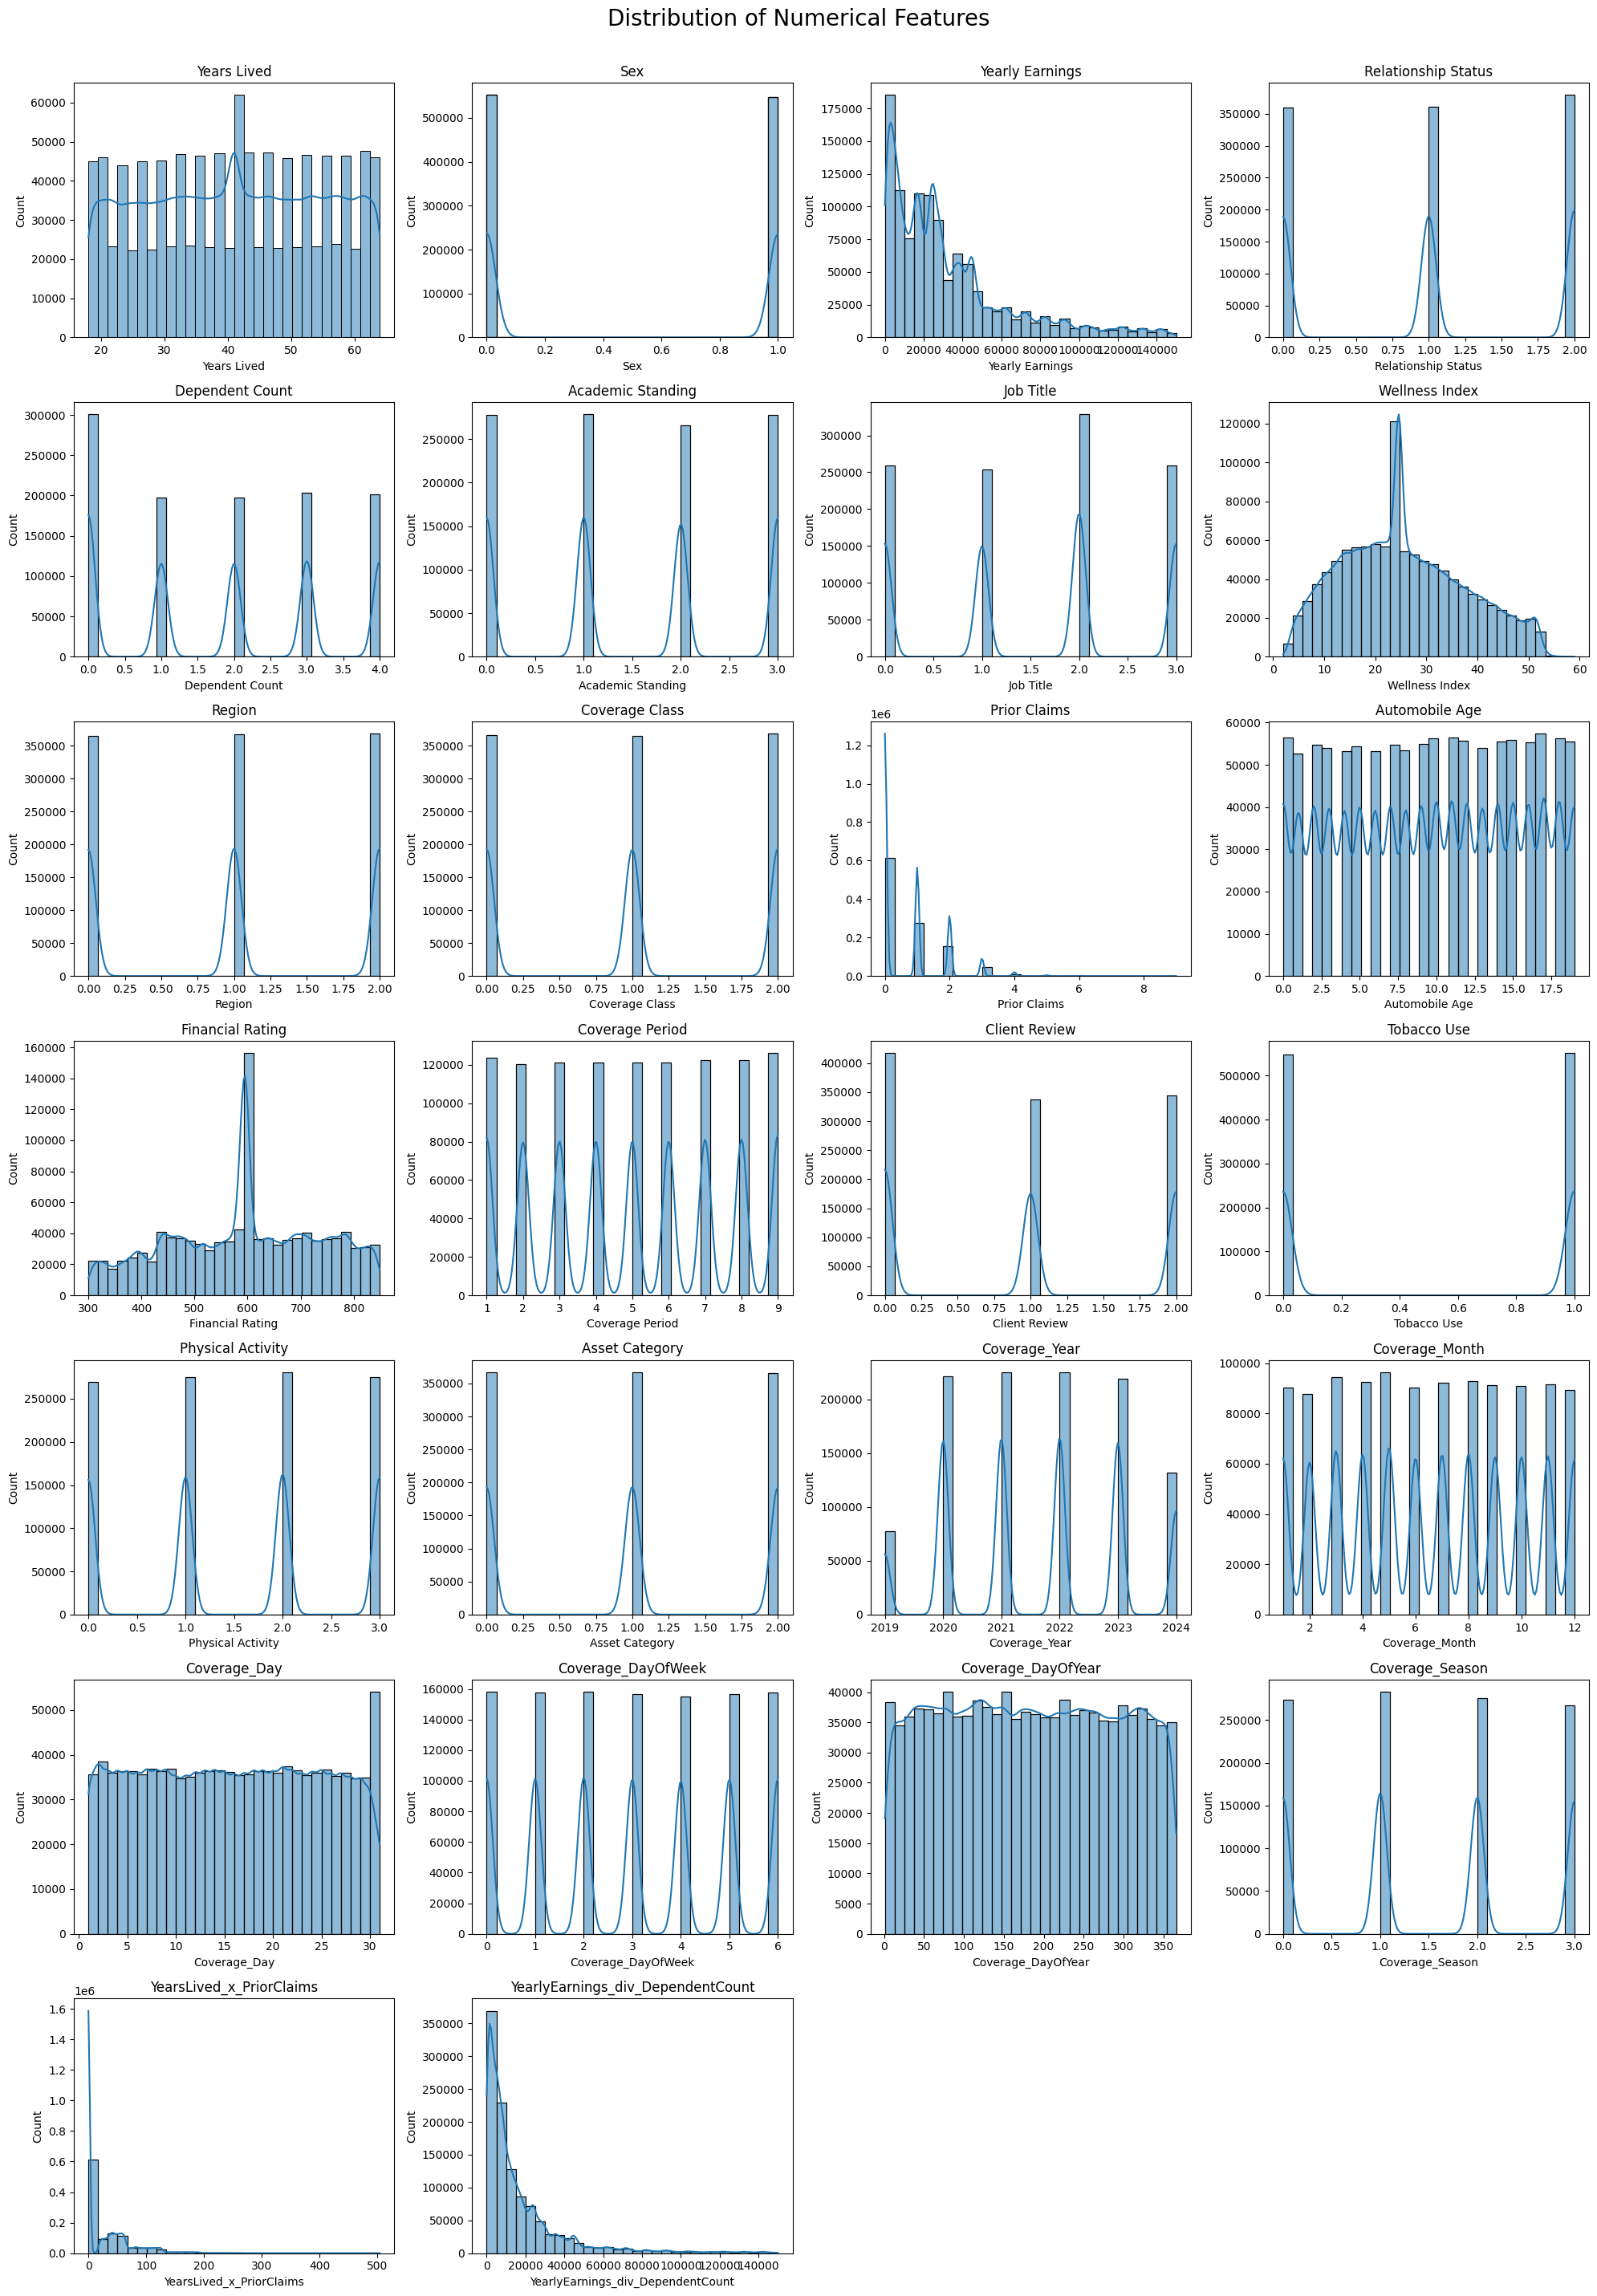

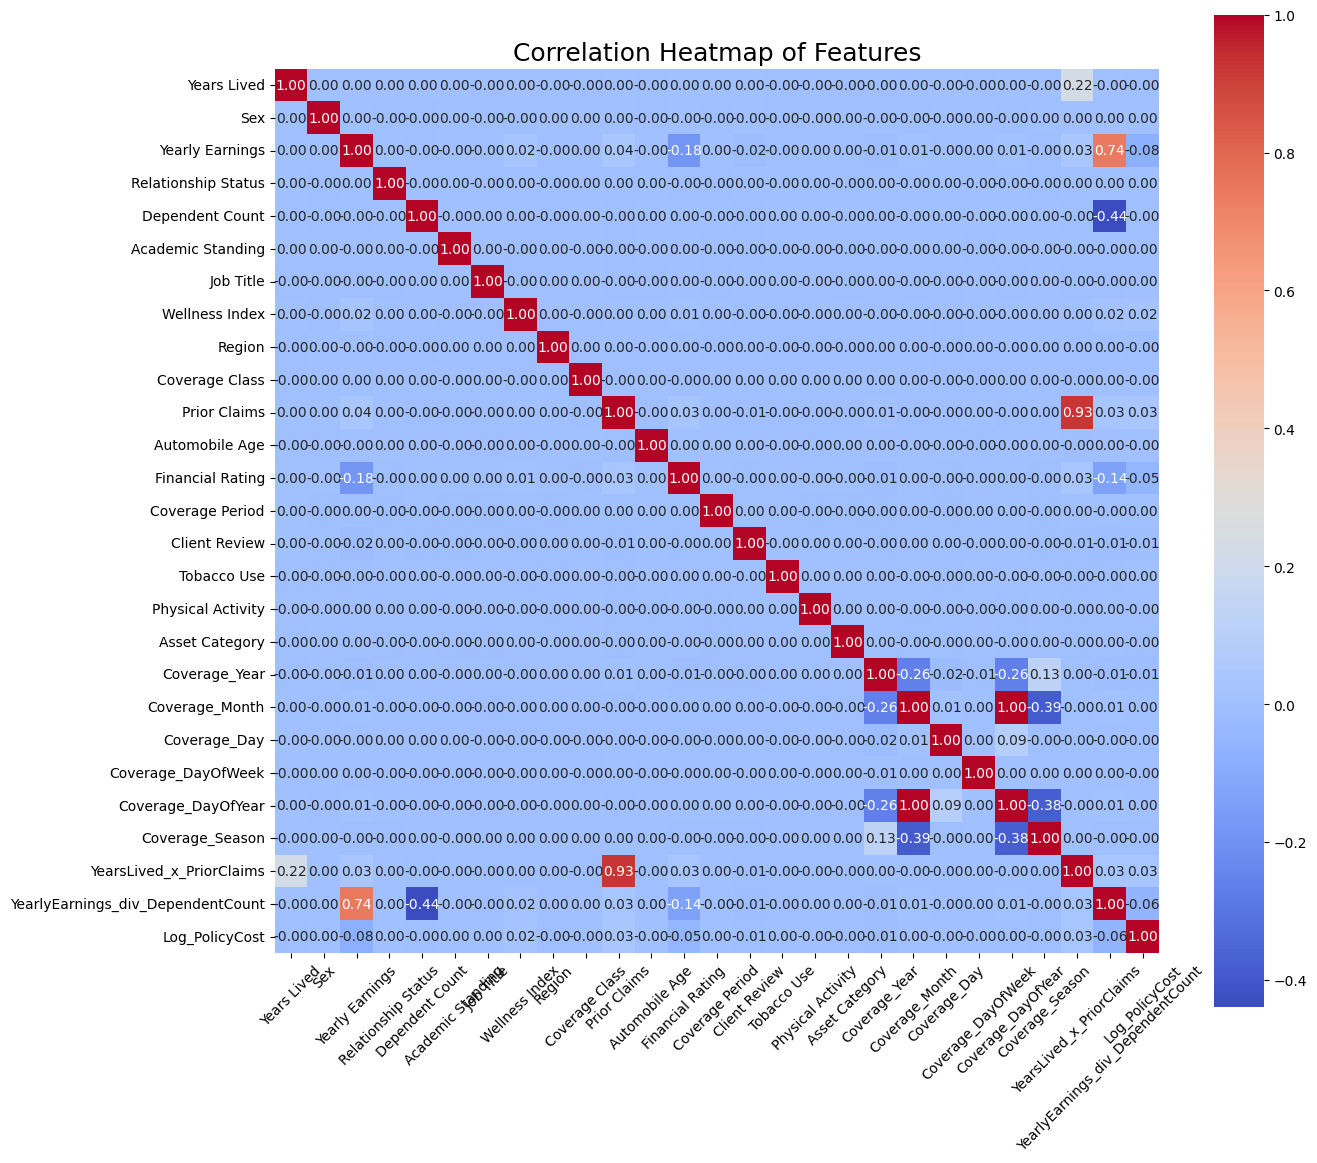

In [22]:

# target distribution
plt.figure(figsize=(10,5))
sns.histplot(train['Policy Cost'], bins=100, kde=True)
plt.title('Distribution of Policy Cost')
plt.show()

#  missing values
missing_train = train.isnull().mean() * 100
missing_test = test.isnull().mean() * 100
print('Missing % in train:\n', missing_train[missing_train>0])
print('Missing % in test:\n', missing_test[missing_test>0])

# Feature Engineering

# Temporal Feature from Coverage Commencement (assuming it's a date string)
def add_date_features(df):
    df['Coverage Commencement'] = pd.to_datetime(df['Coverage Commencement'], errors='coerce')
    df['Coverage_Year'] = df['Coverage Commencement'].dt.year
    df['Coverage_Month'] = df['Coverage Commencement'].dt.month
    df['Coverage_Day'] = df['Coverage Commencement'].dt.day
    df['Coverage_DayOfWeek'] = df['Coverage Commencement'].dt.dayofweek
    df['Coverage_DayOfYear'] = df['Coverage Commencement'].dt.dayofyear

    # Season (Spring=3-5, Summer=6-8, Autumn=9-11, Winter=12-2)
    def season(month):
        if month in [3,4,5]:
            return 'Spring'
        elif month in [6,7,8]:
            return 'Summer'
        elif month in [9,10,11]:
            return 'Autumn'
        else:
            return 'Winter'
    df['Coverage_Season'] = df['Coverage_Month'].apply(season)
    return df

train = add_date_features(train)
test = add_date_features(test)

# Drop original 'Coverage Commencement' after feature extraction
train.drop(columns=['Coverage Commencement'], inplace=True)
test.drop(columns=['Coverage Commencement'], inplace=True)

# Handle missing values

# Fill with zero
fill_zero_cols = ['Dependent Count', 'Prior Claims']
train[fill_zero_cols] = train[fill_zero_cols].fillna(0)
test[fill_zero_cols] = test[fill_zero_cols].fillna(0)

# Fill with median
median_cols = ['Years Lived', 'Yearly Earnings', 'Wellness Index',
               'Automobile Age', 'Financial Rating', 'Coverage Period']

median_imputer = SimpleImputer(strategy='median')
train[median_cols] = median_imputer.fit_transform(train[median_cols])
test[median_cols] = median_imputer.transform(test[median_cols])

# Fill with mode
mode_cols = ['Relationship Status', 'Client Review']

mode_imputer = SimpleImputer(strategy='most_frequent')
train[mode_cols] = mode_imputer.fit_transform(train[mode_cols])
test[mode_cols] = mode_imputer.transform(test[mode_cols])

# Fill Job Title missing with 'Unknown'
train['Job Title'] = train['Job Title'].fillna('Unknown')
test['Job Title'] = test['Job Title'].fillna('Unknown')

# Confirm no missing left
print("Remaining missing values in train:\n", train.isnull().sum()[train.isnull().sum() > 0])
print("Remaining missing values in test:\n", test.isnull().sum()[test.isnull().sum() > 0])

#  Log-transform the target (Policy Cost) to reduce skew
train['Log_PolicyCost'] = np.log1p(train['Policy Cost'])

plt.figure(figsize=(10,5))
sns.histplot(train['Log_PolicyCost'], bins=100, kde=True)
plt.title('Distribution of Log-Transformed Policy Cost')
plt.show()

# Encode categorical variables
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# Add 'Coverage_Season' created earlier (categorical)
cat_cols.append('Coverage_Season')

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    full_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(full_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    label_encoders[col] = le

# Create interaction features example
train['YearsLived_x_PriorClaims'] = train['Years Lived'] * train['Prior Claims']
test['YearsLived_x_PriorClaims'] = test['Years Lived'] * test['Prior Claims']

train['YearlyEarnings_div_DependentCount'] = train['Yearly Earnings'] / (train['Dependent Count'] + 1)
test['YearlyEarnings_div_DependentCount'] = test['Yearly Earnings'] / (test['Dependent Count'] + 1)

# Define features and target
features = [col for col in train.columns if col not in ['ID', 'Policy Cost', 'Log_PolicyCost']]

X = train[features]
y = train['Log_PolicyCost']

X_test = test[features]

# Distribution of Numerical Features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))
plt.figure(figsize=(n_cols*5, n_rows*4))

for idx, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(col)
    plt.tight_layout()

plt.suptitle('Distribution of Numerical Features', fontsize=20, y=1.02)
plt.show()

#  Correlation Heatmap
corr_matrix = train[num_cols + ['Log_PolicyCost']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True, cbar=True)
plt.title('Correlation Heatmap of Features', fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
#  Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)



LR

In [6]:
# Model 1: Linear Regression (with scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_val_lr = lr.predict(X_val_scaled)

print(f"Linear Regression RMSLE: {rmsle(np.expm1(y_val), np.expm1(y_pred_val_lr)):.4f}")

# Predict on test set and save submission
y_test_pred_log_lr = lr.predict(X_test_scaled)
y_test_pred_lr = np.expm1(y_test_pred_log_lr)
submission_lr = submission.copy()
submission_lr['Policy Cost'] = y_test_pred_lr
submission_lr.to_csv('submission_linear_regression.csv', index=False)
from google.colab import files
files.download("submission_linear_regression.csv")
print("Linear Regression submission saved to 'submission_linear_regression.csv'")

Linear Regression RMSLE: 1.0900


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Linear Regression submission saved to 'submission_linear_regression.csv'


RF

In [9]:
#  Model 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_val_rf = rf.predict(X_val)

print(f"Random Forest RMSLE: {rmsle(np.expm1(y_val), np.expm1(y_pred_val_rf)):.4f}")

# Predict on test set and save submission
y_test_pred_log_rf = rf.predict(X_test)
y_test_pred_rf = np.expm1(y_test_pred_log_rf)
submission_rf = submission.copy()
submission_rf['Policy Cost'] = y_test_pred_rf
submission_rf.to_csv('submission_random_forest.csv', index=False)
from google.colab import files
files.download("submission_random_forest.csv")
print("Random Forest submission saved to 'submission_random_forest.csv'")

Random Forest RMSLE: 1.0544


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest submission saved to 'submission_random_forest.csv'


CatBoost

In [26]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Initialize CatBoost
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

# Fit model
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Validation predictions
y_pred_val_cat = cat_model.predict(X_val)
print(f"CatBoost RMSLE: {rmsle(np.expm1(y_val), np.expm1(y_pred_val_cat)):.4f}")

# Predict on test set
y_test_pred_log_cat = cat_model.predict(X_test)
y_test_pred_cat = np.expm1(y_test_pred_log_cat)

# Save submission
submission_cat = submission.copy()
submission_cat['Policy Cost'] = y_test_pred_cat
submission_cat.to_csv('submission_catboost.csv', index=False)

from google.colab import files
files.download("submission_catboost.csv")
print("CatBoost submission saved to 'submission_catboost.csv'")


0:	learn: 1.0931668	test: 1.0945952	best: 1.0945952 (0)	total: 308ms	remaining: 5m 7s
100:	learn: 1.0556170	test: 1.0579216	best: 1.0579216 (100)	total: 21.1s	remaining: 3m 8s
200:	learn: 1.0537536	test: 1.0564940	best: 1.0564940 (200)	total: 42.2s	remaining: 2m 47s
300:	learn: 1.0526196	test: 1.0558091	best: 1.0558081 (299)	total: 1m 1s	remaining: 2m 23s
400:	learn: 1.0517015	test: 1.0553510	best: 1.0553510 (400)	total: 1m 22s	remaining: 2m 2s
500:	learn: 1.0510349	test: 1.0552207	best: 1.0552207 (500)	total: 1m 40s	remaining: 1m 40s
600:	learn: 1.0503775	test: 1.0551005	best: 1.0550998 (598)	total: 1m 59s	remaining: 1m 19s
700:	learn: 1.0497804	test: 1.0549788	best: 1.0549788 (700)	total: 2m 19s	remaining: 59.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.054945918
bestIteration = 729

Shrink model to first 730 iterations.
CatBoost RMSLE: 1.0549


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CatBoost submission saved to 'submission_catboost.csv'


Model Interpretation

Top 10 Important Features from Random Forest:
Yearly Earnings                      0.204959
Wellness Index                       0.167291
Financial Rating                     0.160656
Prior Claims                         0.068458
YearlyEarnings_div_DependentCount    0.051496
Coverage_DayOfYear                   0.045799
Coverage_Year                        0.037460
Years Lived                          0.034279
Coverage_Day                         0.032016
Automobile Age                       0.029493
dtype: float64 



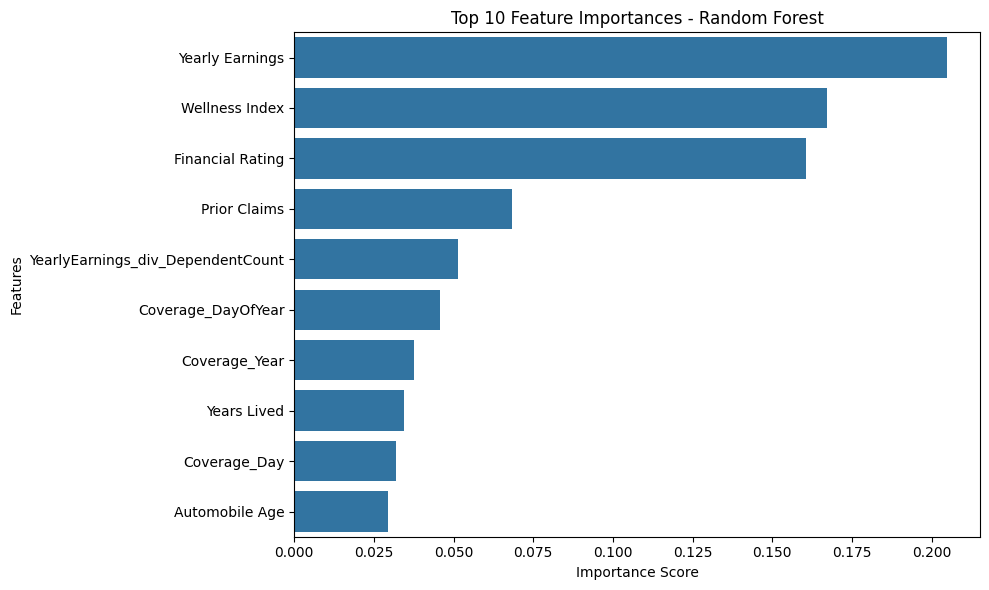

Top 10 Important Features from CatBoost:
Yearly Earnings                      45.220709
Financial Rating                     22.715155
Wellness Index                       14.014357
Prior Claims                          9.511444
Coverage_Year                         2.987809
Client Review                         1.004887
YearlyEarnings_div_DependentCount     0.995918
YearsLived_x_PriorClaims              0.633007
Years Lived                           0.394755
Coverage_DayOfYear                    0.360931
dtype: float64 



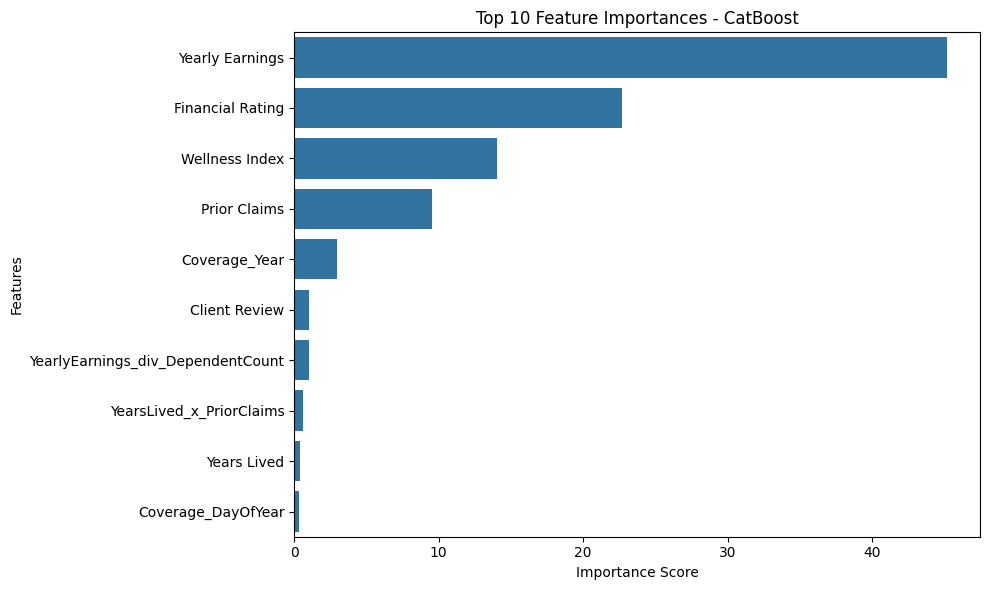

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Random Forest Feature Importances
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 10 Important Features from Random Forest:")
print(rf_importances.head(10), '\n')  # Print top 10 features

plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances[:10], y=rf_importances.index[:10])
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# CatBoost Feature Importances
cat_importances = pd.Series(cat_model.get_feature_importance(), index=X_train.columns).sort_values(ascending=False)
print("Top 10 Important Features from CatBoost:")
print(cat_importances.head(10), '\n')  # Print top 10 features

plt.figure(figsize=(10,6))
sns.barplot(x=cat_importances[:10], y=cat_importances.index[:10])
plt.title("Top 10 Feature Importances - CatBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
